# Learning how to make a Jupyter Notebook

In [1]:
import numpy
import scipy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import sys

sys.path.append('../site-packages')
from gab import phs2

In [2]:
myFigWidth = 10
myFigHeight = 7

## 1D plotting

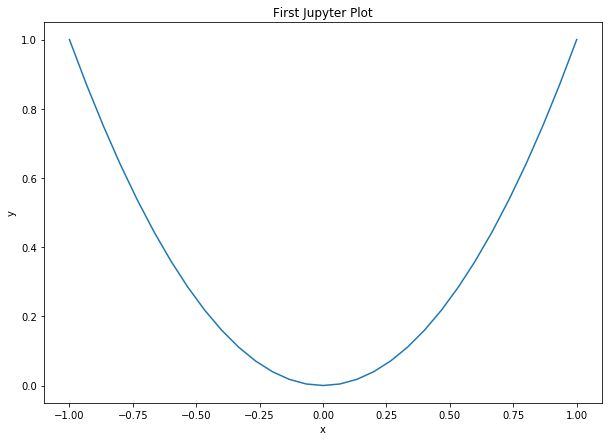

In [3]:
x = numpy.linspace( -1, 1, 31 )
y = x**2

plt.figure( figsize=(myFigWidth,myFigHeight) )
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('First Jupyter Plot')
plt.show()

## Polyharmonic Spline (PHS) Interpolation in 2D

The regular definition of the PHS RBF in $\mathbb{R}^d$ is
\begin{align*}
\phi(r)=&r^5,\\
r\left(\mathbf{x}\right)=&\|\mathbf{x}\|_2=\sqrt{\sum_{i=1}^dx_i^2}.
\end{align*}
The RBF interpolant has the form
\begin{align*}
\Phi\left(\mathbf{x}\right)=&\sum_{j=1}^n\lambda_j\phi\left(r\left(\mathbf{x}-\mathbf{x}_j\right)\right)+\sum_{k=1}^m\mu_kp_k\left(\mathbf{x}\right),
\end{align*}
where $\left\{p_k\left(\mathbf{x}\right)\right\}_{k=1}^m$ is a basis for polynomials up to some degree in $\mathbb{R}^d$.  Enforcing the interpolation conditions and $m$ additional constraints leads to a square linear system to be solved:
\begin{align*}
\left[\begin{matrix}
A   & P \\
P^T & O
\end{matrix}\right]
\left[\begin{matrix}
\lambda \\
\mu
\end{matrix}\right]
=&\left[\begin{matrix}
f \\
0
\end{matrix}\right],
\end{align*}
where the matrices $A$ and $P$ are defined as follows.
\begin{align*}
a_{ij}=&\phi\left(r\left(\mathbf{x}_i-\mathbf{x}_j\right)\right),\quad i,j=1,2,3,\ldots,n,\\
p_{ik}=&p_k\left(\mathbf{x}_i\right), \quad i=1,2,3,\ldots,n,\quad k=1,2,3,\ldots,m.
\end{align*}

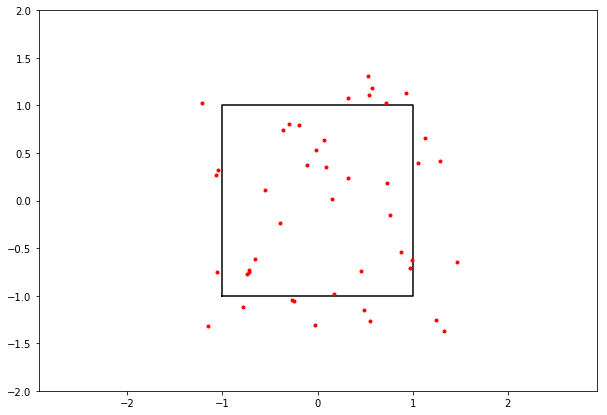

In [4]:
#parameters for the problem:
n = 45                  #number of RBFs (also number of random nodes)
np = 10                 #number of polynomials
rbfparam = 5            #PHS exponent
def trueFunction(x,y):
    k = 1
    z = numpy.exp(-k**2*((x-.1)**2+(y-.4)**2))
    #z = numpy.cos(k*numpy.pi*(x-.1)) * numpy.sin(k*numpy.pi*(y-numpy.exp(-2)))
    return z

mn = phs2.getMN()
x = -1.5 + 3*numpy.random.rand(n)
y = -1.5 + 3*numpy.random.rand(n)
f = trueFunction(x,y)

#plot random points in 2D:
plt.figure( figsize=(myFigWidth,myFigHeight) )
plt.plot( [-1,1,1,-1,-1], [-1,-1,1,1,-1], 'k' )
plt.plot( x, y, 'r.' )
plt.axis( 'equal' )
plt.axis( [-2,2,-2,2] )
plt.show()

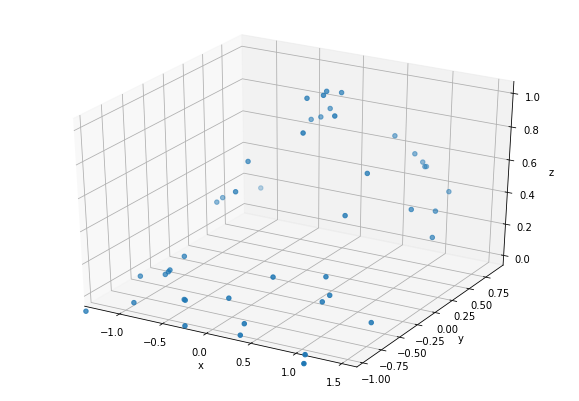

In [5]:
#3D scatter plot of given information (function values):

fig = plt.figure( figsize=(myFigWidth,myFigHeight) )
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,f)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.axis('equal')
plt.show()

In [6]:
#get evaluation points on Cartesian lattice:

N = 51;
X = numpy.linspace( -1, 1, N )
N = N**2                                   #total number of evaluation points
X,Y = numpy.meshgrid( X, X )
X = X.flatten()
Y = Y.flatten()
F = trueFunction( X, Y )

In [7]:
#solve linear system to get RBF coefficients (lam):

A = numpy.zeros(( n+np, n+np ))
b = numpy.zeros(( n+np, 1 ))
for i in range(n) :
    b[i] = f[i]
    for j in range(np) :
        A[i,j] = phs2.phi( 1 , x[i]-x[j], y[i]-y[j], rbfparam )
        tmp = x[i]**mn[j,0] * y[i]**mn[j,1]
        A[i,n+j] = tmp
        A[n+j,i] = tmp
    for j in numpy.arange(np,n) :
        A[i,j] = phs2.phi( 1 , x[i]-x[j], y[i]-y[j], rbfparam )
lam = scipy.linalg.solve(A,b)

In [8]:
#get the RBF approximation on the evaluation points:
B = numpy.zeros(( N, n+np ))
for i in range(N) :
    for j in range(np) :
        B[i,j] = phs2.phi( 1 , X[i]-x[j], Y[i]-y[j], rbfparam )
        B[i,n+j] = X[i]**mn[j,0] * Y[i]**mn[j,1]
    for j in numpy.arange(np,n) :
        B[i,j] = phs2.phi( 1 , X[i]-x[j], Y[i]-y[j], rbfparam )
approx = numpy.matmul( B, lam )
approx = approx.flatten()

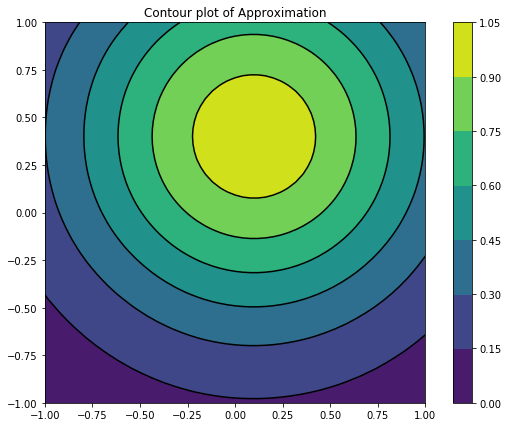

In [9]:
#contour plot of approximation:

triang = tri.Triangulation( X, Y )
plt.figure( figsize=(myFigWidth,myFigHeight) )
plt.gca().set_aspect('equal')
plt.tricontourf( triang, approx )
plt.colorbar()
plt.tricontour( triang, approx, colors='k' )
plt.title('Contour plot of Approximation')
plt.show()

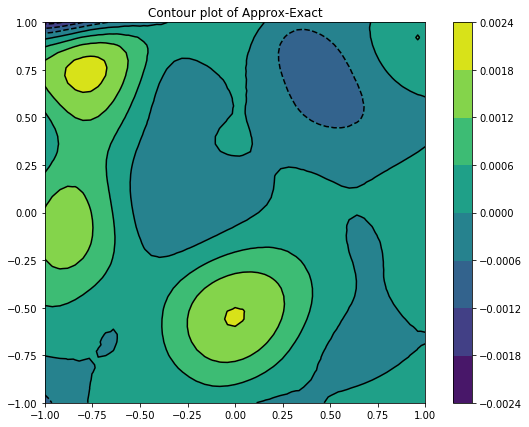

In [10]:
#contour of the error over [-1/2,1/2]x[-1/2,1/2]:

plt.figure( figsize=(myFigWidth,myFigHeight) )
plt.gca().set_aspect('equal')
plt.tricontourf( triang, approx-F )
plt.colorbar()
plt.tricontour( triang, approx-F, colors='k' )
plt.title('Contour plot of Approx-Exact')
plt.show()

## Degrees of Freedom on the Sphere

In [11]:
ell = 20000

In [12]:
# approximate number of equilateral triangles to cover Earth:

h = numpy.sqrt( ell**2 - (ell/2)**2 )
A = 1/2 * ell * h
nCells = 4*numpy.pi*(6.37122e6)**2 / A
print(nCells)

2945061.985720513


In [13]:
#approximate number of squares to cover Earth:
A = ell**2
nCells = 4*numpy.pi*(6.37122e6)**2 / A
print(nCells)

1275249.2476769038
